* plot temp and salinity contour plots
* save front name and fastCTD stop and end times for referencing for ADCP later (compare to adrien's)
* plot adcp
* plot ship track on top of modis, get front crossing angle
* frontal coordinates
* ship met (winds, pressure, temp, sal, etc.)
* plot stretched 10 km 

## FastCTD

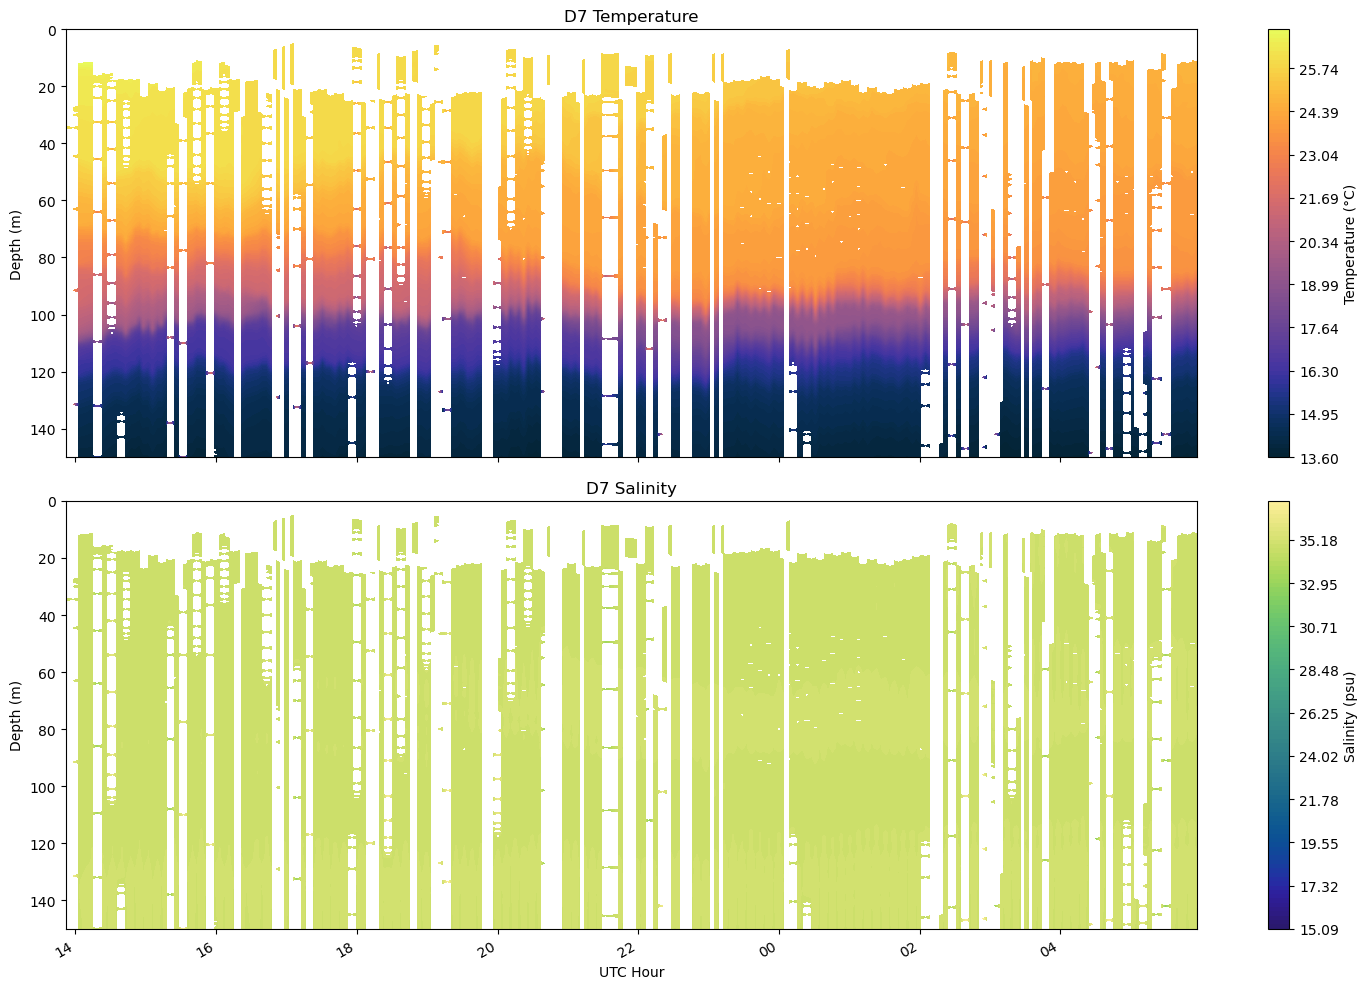

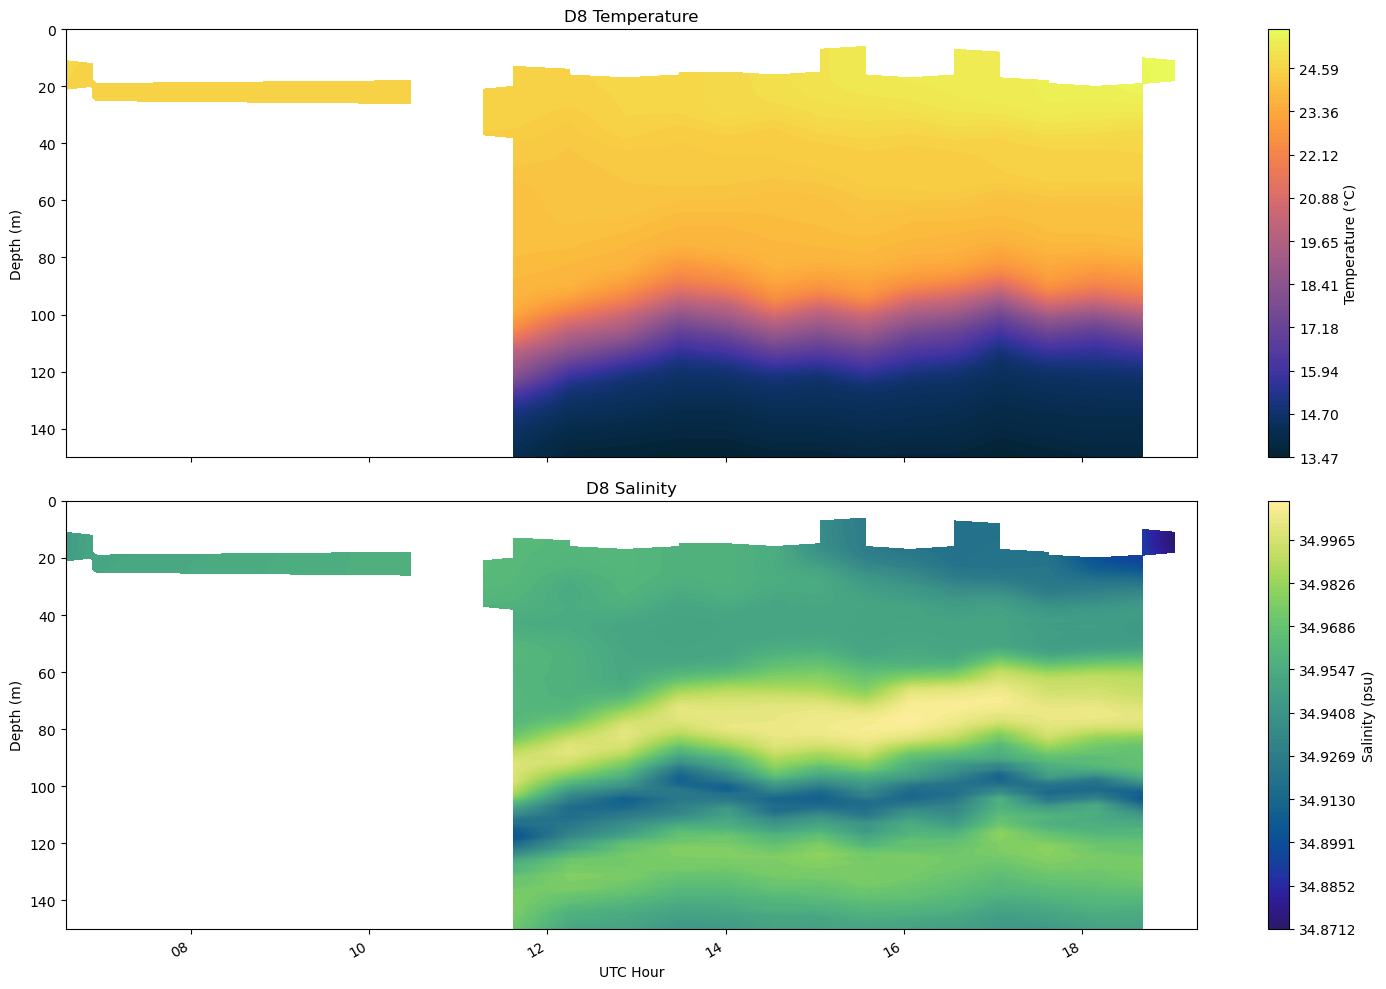

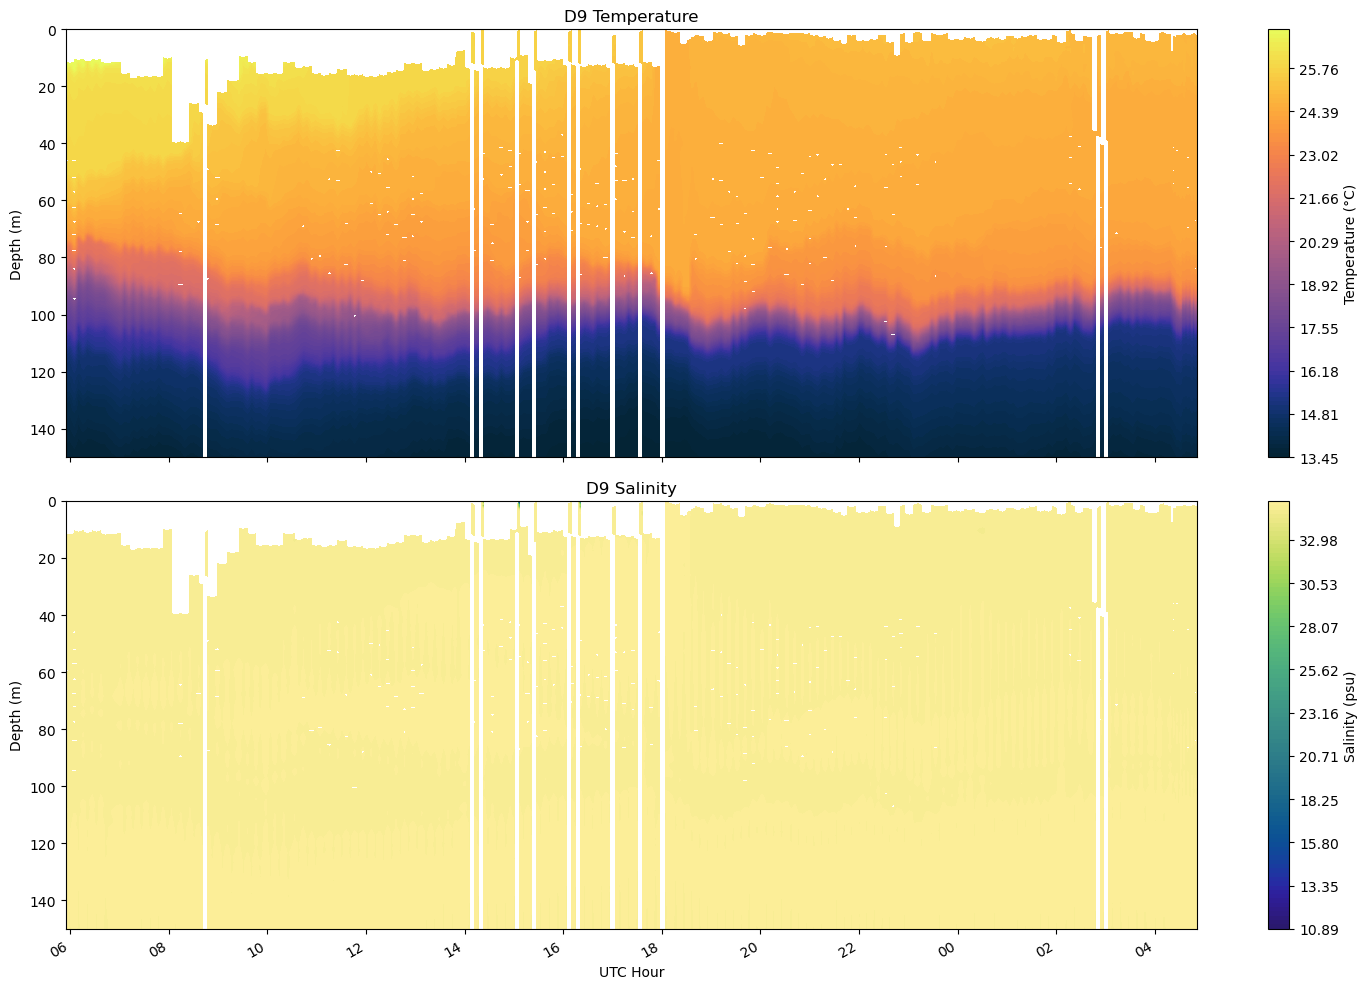

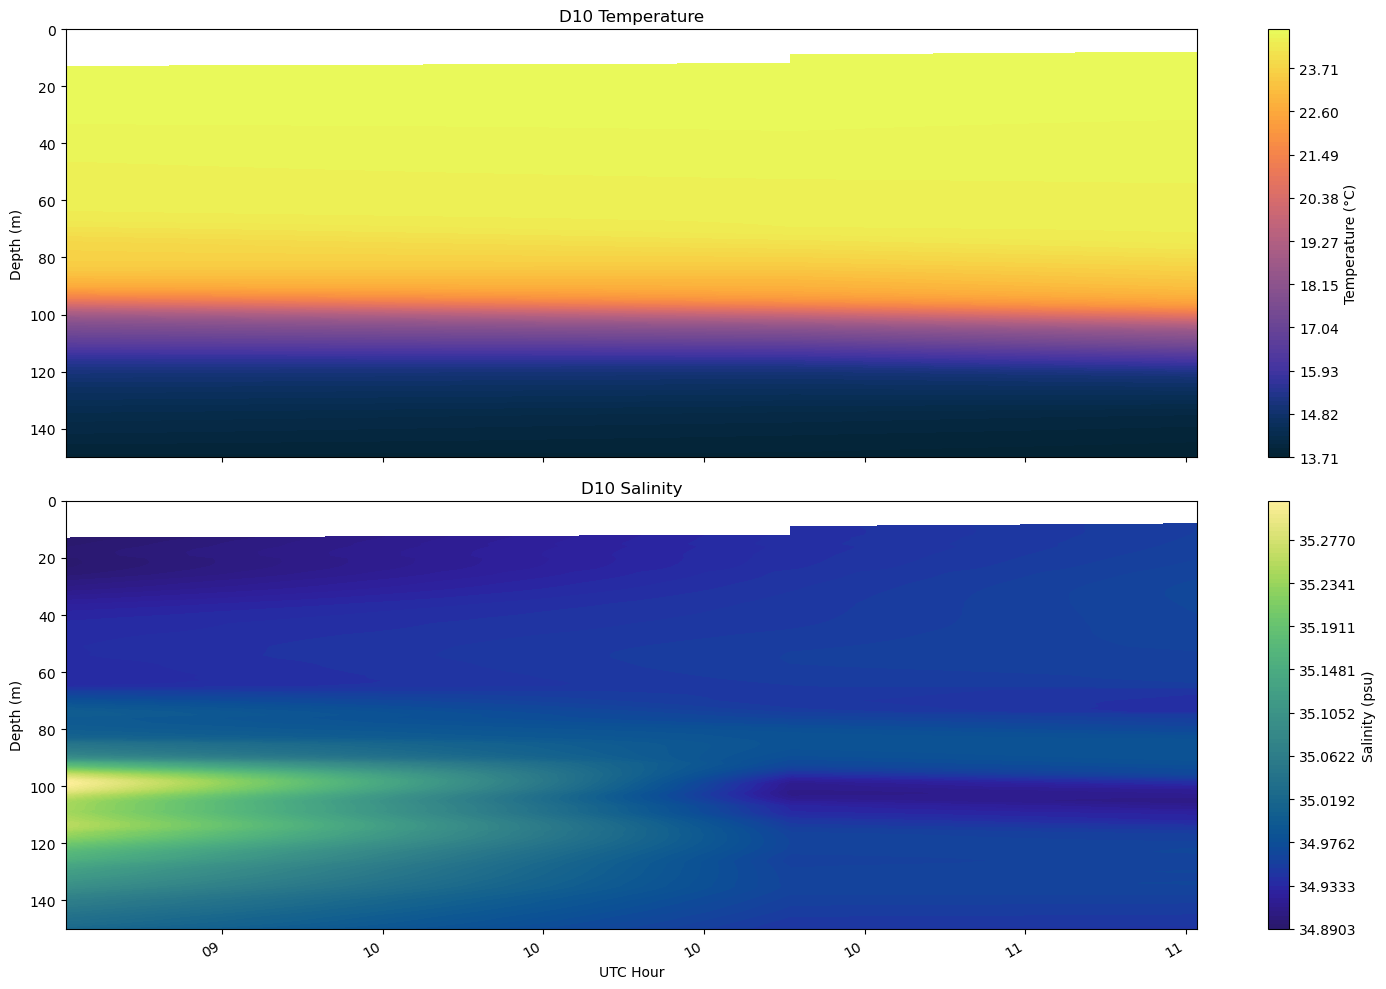

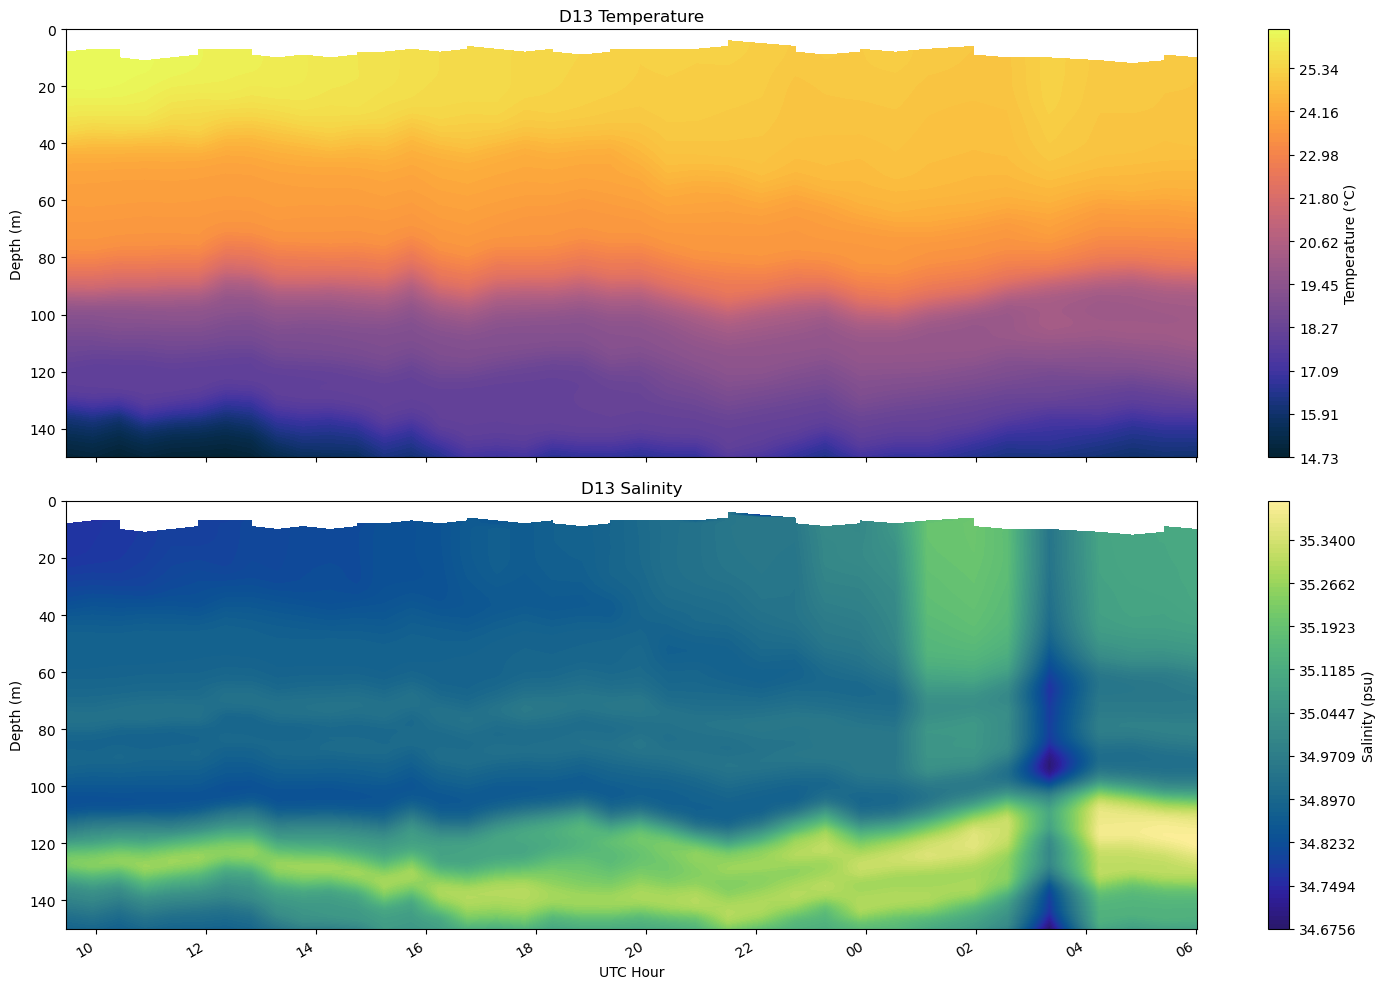

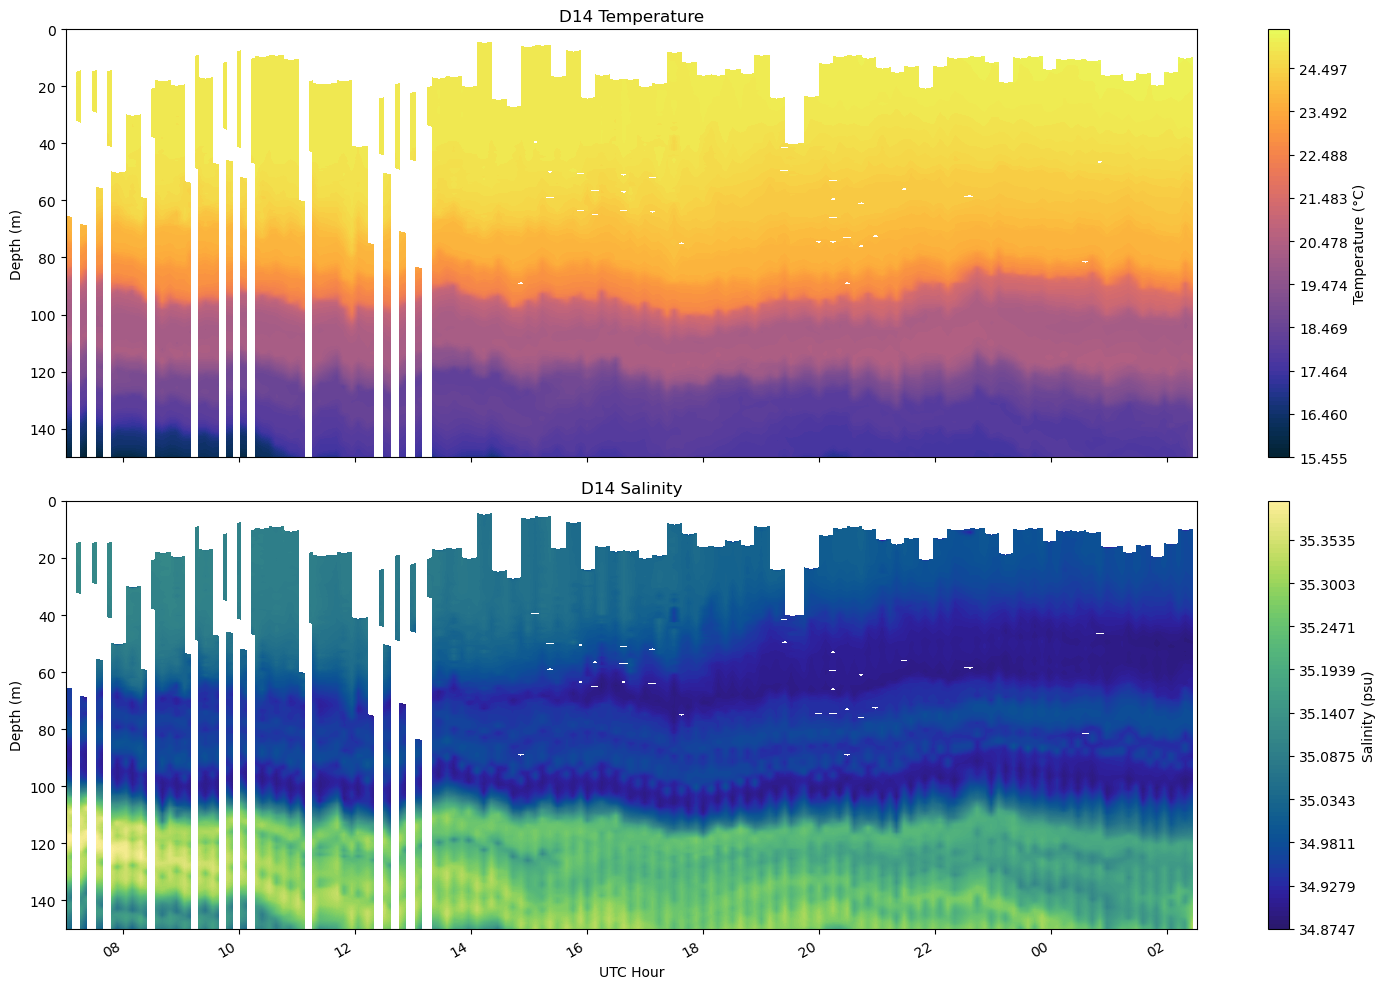

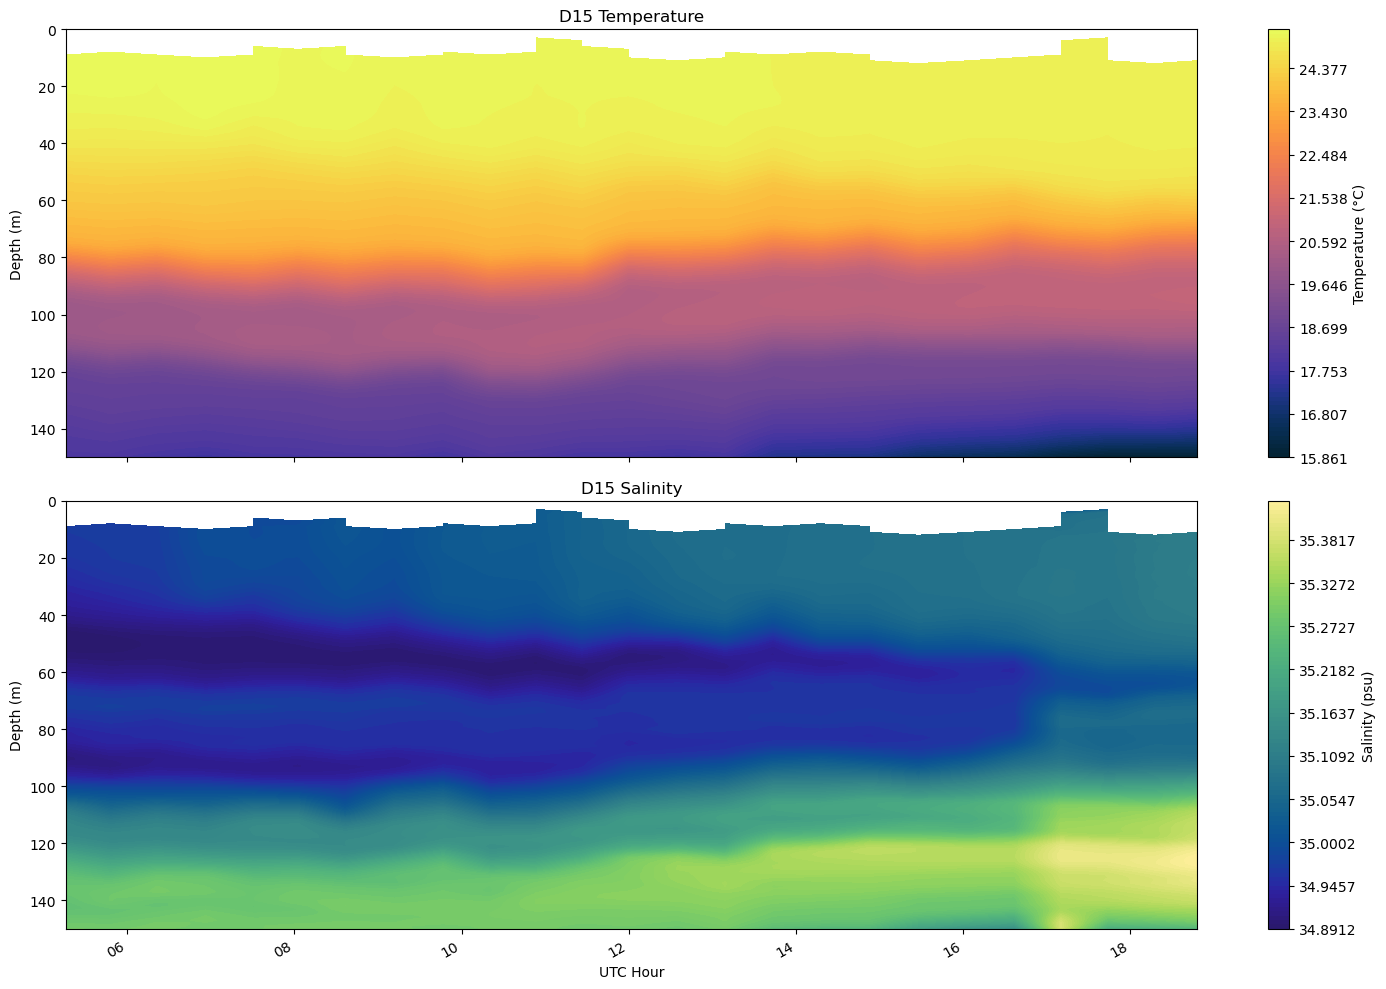

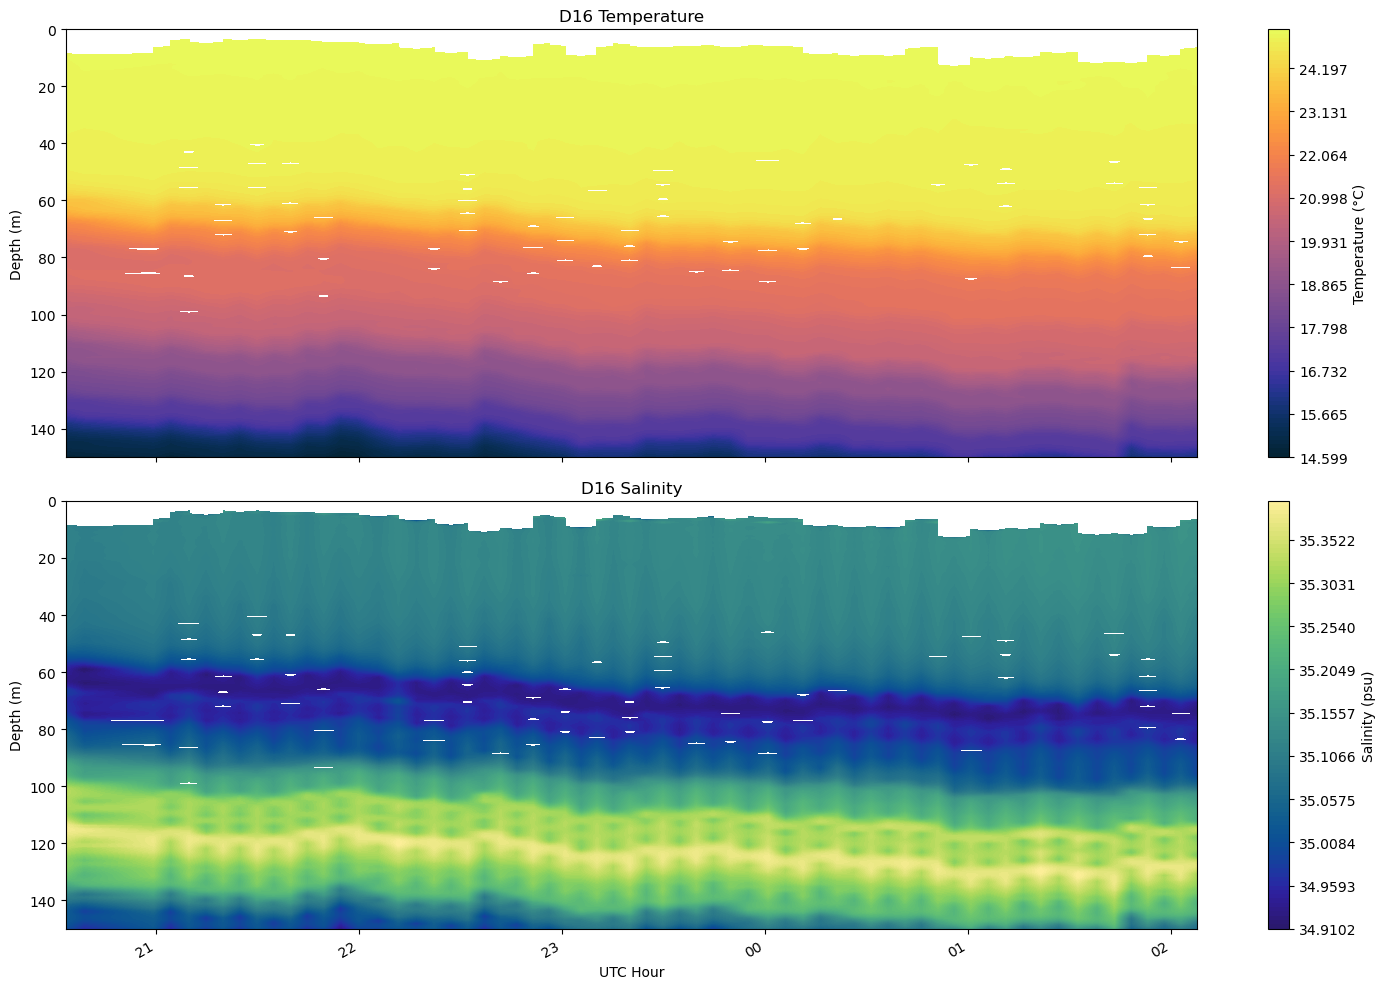

In [2]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean
import datetime

# MATLAB datenum → Python datetime
def datenum_to_datetime_safe(matlab_datenum):
    if np.isnan(matlab_datenum):
        return None  # or some default datetime if needed
    day = datetime.datetime.fromordinal(int(matlab_datenum))
    dayfrac = datetime.timedelta(days=matlab_datenum % 1)
    return day + dayfrac - datetime.timedelta(days=366)



# List of fronts
fronts = ['D7','D8','D9','D10','D13','D14','D15','D16']

base_dir = '/Volumes/external/MOTIVE/data/'

for front in fronts:
    folder = os.path.join(base_dir, front)
    
    # Look for the .mat file we expect
    matfile_fctd = os.path.join(folder, 'FCTDgrid.mat')
    matfile_grid = os.path.join(folder, 'griddedProfiles.mat')
    
    if os.path.isfile(matfile_fctd):
        mat = sio.loadmat(matfile_fctd, struct_as_record=False, squeeze_me=True)
        fctd = mat['FCTDgrid']
        # Extract variables
        time = fctd.time
        depth = fctd.depth
        temperature = fctd.temperature
        salinity = fctd.salinity
        
    elif os.path.isfile(matfile_grid):
        mat = sio.loadmat(matfile_grid, struct_as_record=False, squeeze_me=True)
        grid = mat['GRID']
        time = grid.dnum
        depth = grid.pr
        temperature = grid.t
        salinity = grid.s
        
    else:
        print(f"No expected .mat file found in {folder}, skipping.")
        continue
    
    time_dt = [datenum_to_datetime_safe(t) for t in np.ravel(time)]
    
    # Filter out None values (NaNs) and keep indices
    valid_idx = [i for i, dt in enumerate(time_dt) if dt is not None]
    
    # Then slice your data arrays accordingly to keep only valid times
    time_dt = [time_dt[i] for i in valid_idx]
    temperature = temperature[:, valid_idx]
    salinity = salinity[:, valid_idx]
    
    # If temperature or salinity are 1D, try to reshape to 2D (depth x time)
    if temperature.ndim == 1:
        temperature = temperature.reshape((len(depth), len(time_dt)))
    if salinity.ndim == 1:
        salinity = salinity.reshape((len(depth), len(time_dt)))
    

    # Limit depth to 150m (slice data accordingly)
    depth_limit = 150
    depth_mask = depth <= depth_limit
    
    depth_sub = depth[depth_mask]
    temperature_sub = temperature[depth_mask, :]
    salinity_sub = salinity[depth_mask, :]
    
    # Create figure with 2 subplots, sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Temperature panel
    cf1 = ax1.contourf(time_dt, depth_sub, temperature_sub,
                       levels=np.linspace(np.nanmin(temperature_sub), np.nanmax(temperature_sub), 100),
                       cmap=cmocean.cm.thermal)
    cbar1 = fig.colorbar(cf1, ax=ax1, label="Temperature (°C)")
    ax1.set_ylim(depth_limit, 0)  # invert y-axis
    ax1.set_ylabel("Depth (m)")
    ax1.set_title(f"{front} Temperature")
    
    # Salinity panel
    cf2 = ax2.contourf(time_dt, depth_sub, salinity_sub,
                       levels=np.linspace(np.nanmin(salinity_sub), np.nanmax(salinity_sub), 100),
                       cmap=cmocean.cm.haline)
    cbar2 = fig.colorbar(cf2, ax=ax2, label="Salinity (psu)")
    ax2.set_ylim(depth_limit, 0)  # invert y-axis
    ax2.set_ylabel("Depth (m)")
    ax2.set_xlabel("UTC Hour")
    ax2.set_title(f"{front} Salinity")
    
    # Format x-axis ticks as UTC hour
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()


    # Save figure
    save_path = os.path.join(folder, f"{front}_temp_salinity.png")
    fig.savefig(save_path)
    plt.close(fig)

## ADCP

In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean
import xarray as xr
ds = xr.open_dataset('/Volumes/external/MOTIVE/data/wh300.nc')

# Load CSV with time ranges
csv_file = '/Volumes/external/MOTIVE/data/fastCTD_ranges_time_ranges.csv'
time_ranges = pd.read_csv(csv_file, parse_dates=['start_time_UTC', 'end_time_UTC'])

# Base directory with front folders
base_dir = '/Volumes/external/MOTIVE/data/'

# Loop through fronts and plot ADCP
for _, row in time_ranges.iterrows():
    front = row['front']
    t0 = row['start_time_UTC']
    t1 = row['end_time_UTC']
    
    folder = os.path.join(base_dir, front)
    
    # Slice ADCP dataset to this time window
    ds_sel = ds.sel(time=slice(t0, t1))
    
    if ds_sel.time.size == 0:
        print(f"No ADCP data found for {front} between {t0} and {t1}")
        continue
    
    u = ds_sel.u
    v = ds_sel.v
    time = ds_sel.time.values
    depth = ds_sel.depth.isel(time=0).values  # depth per cell
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # --- U velocity ---
    cf1 = ax1.contourf(time, depth, u.T,  # transpose: depth on y-axis
                       levels=100, cmap=cmocean.cm.balance)
    fig.colorbar(cf1, ax=ax1, label='U (m/s)')
    ax1.set_ylim(depth.max(), depth.min())  # invert y-axis
    ax1.set_ylabel('Depth (m)')
    ax1.set_title(f'{front} U Velocity (m/s)')
    
    # --- V velocity ---
    cf2 = ax2.contourf(time, depth, v.T,
                       levels=100, cmap=cmocean.cm.balance)
    fig.colorbar(cf2, ax=ax2, label='V (m/s)')
    ax2.set_ylim(depth.max(), depth.min())
    ax2.set_ylabel('Depth (m)')
    ax2.set_xlabel('Time')
    ax2.set_title(f'{front} V Velocity (m/s)')
    
    # Format time axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    fig.autofmt_xdate()
    
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(folder, f"{front}_ADCP_UV.png")
    fig.savefig(save_path)
    plt.close(fig)
    
    print(f"Saved ADCP U/V plot for {front} at {save_path}")


Saved ADCP U/V plot for D7 at /Volumes/external/MOTIVE/data/D7/D7_ADCP_UV.png
Saved ADCP U/V plot for D8 at /Volumes/external/MOTIVE/data/D8/D8_ADCP_UV.png
Saved ADCP U/V plot for D9 at /Volumes/external/MOTIVE/data/D9/D9_ADCP_UV.png
Saved ADCP U/V plot for D10 at /Volumes/external/MOTIVE/data/D10/D10_ADCP_UV.png
Saved ADCP U/V plot for D13 at /Volumes/external/MOTIVE/data/D13/D13_ADCP_UV.png
Saved ADCP U/V plot for D14 at /Volumes/external/MOTIVE/data/D14/D14_ADCP_UV.png
Saved ADCP U/V plot for D15 at /Volumes/external/MOTIVE/data/D15/D15_ADCP_UV.png
Saved ADCP U/V plot for D16 at /Volumes/external/MOTIVE/data/D16/D16_ADCP_UV.png


## Ship flowthrough and met data

In [105]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np

# === Load ship dataset ===
ds_ship = xr.open_dataset('/Volumes/external/MOTIVE/data/skq202417s_met.nc')

# === Load time ranges from earlier step ===
csv_file = '/Volumes/external/MOTIVE/data/fastCTD_ranges_time_ranges.csv'
time_ranges = pd.read_csv(csv_file, parse_dates=['start_time_UTC', 'end_time_UTC'])

# === Base directory with front folders ===
base_dir = '/Volumes/external/MOTIVE/data/'

# Loop through each front
for _, row in time_ranges.iterrows():
    front = row['front']
    t0 = row['start_time_UTC']
    t1 = row['end_time_UTC']
    
    folder = os.path.join(base_dir, front)
    
    # Slice ship dataset to time range
    ds_sel = ds_ship.sel(time=slice(t0, t1))
    if ds_sel.time.size == 0:
        print(f"No ship data found for {front} between {t0} and {t1}")
        continue
    
    # Extract variables
    time = ds_sel.time.values
    t = ds_sel['t'].values                  # seawater temperature
    s = ds_sel['s'].values                  # salinity
    p = ds_sel['barometric_pressure'].values
    tair = ds_sel['air_temperature'].values
    rh = ds_sel['relative_humidity'].values
    wspd = ds_sel['wind_spd_ms'].values     # m/s
    wdir = ds_sel['wind_dir'].values        # deg from
    
    # Convert wind to vector components for quiver
    u_wind = -wspd * np.sin(np.deg2rad(wdir))  # meteorological to math coords
    v_wind = -wspd * np.cos(np.deg2rad(wdir))
    
    # === Create figure with subpanels ===
    fig, axes = plt.subplots(6, 1, figsize=(15, 15), sharex=True)
    
    # Temperature
    axes[0].plot(time, t, color='red')
    axes[0].set_ylabel('T (°C)')
    axes[0].set_title(f'{front} Ship Flowthrough & Met Data')
    
    # Salinity
    axes[1].plot(time, s, color='blue')
    axes[1].set_ylabel('S (psu)')
    
    # Pressure
    axes[2].plot(time, p, color='black')
    axes[2].set_ylabel('Pressure (hPa)')
    
    # Air Temperature
    axes[3].plot(time, tair, color='orange')
    axes[3].set_ylabel('Air T (°C)')
    
    # Relative Humidity
    axes[4].plot(time, rh, color='green')
    axes[4].set_ylabel('RH (%)')
    
    # Wind Vectors
    step = max(1, len(time)//30)  # subsample to avoid overcrowding
    Q = axes[5].quiver(time[::step], [0]*len(time[::step]),
                       u_wind[::step], v_wind[::step],
                       scale=100, width=0.004, headwidth=3, headlength=5)
    
    axes[5].set_ylim(-1, 1)
    axes[5].set_ylabel('Wind')
    
    # Add reference vector (10 m/s to the east)
    axes[5].quiverkey(Q, 0.95, 0.1, 5, "5 m/s", labelpos='E',color='gray')

    
    # Format x-axis as UTC time
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    fig.autofmt_xdate()
    axes[-1].set_xlabel('UTC Time')
    
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(folder, f"{front}_ship_met.png")
    fig.savefig(save_path)
    plt.close(fig)
    
    print(f"Saved ship flowthrough/met plot for {front} at {save_path}")


Saved ship flowthrough/met plot for D7 at /Volumes/external/MOTIVE/data/D7/D7_ship_met.png
Saved ship flowthrough/met plot for D8 at /Volumes/external/MOTIVE/data/D8/D8_ship_met.png
Saved ship flowthrough/met plot for D9 at /Volumes/external/MOTIVE/data/D9/D9_ship_met.png
Saved ship flowthrough/met plot for D10 at /Volumes/external/MOTIVE/data/D10/D10_ship_met.png
Saved ship flowthrough/met plot for D13 at /Volumes/external/MOTIVE/data/D13/D13_ship_met.png
Saved ship flowthrough/met plot for D14 at /Volumes/external/MOTIVE/data/D14/D14_ship_met.png
Saved ship flowthrough/met plot for D15 at /Volumes/external/MOTIVE/data/D15/D15_ship_met.png
Saved ship flowthrough/met plot for D16 at /Volumes/external/MOTIVE/data/D16/D16_ship_met.png


## Satellite and ship tracks + xband on top

In [ ]:



# download closest modis (may need to play with clouds)
# put xband on top as movie?  

In [20]:
import xarray as xr
ds_mur=xr.open_dataset('/Volumes/external/MOTIVE/data/MUR/MUR_sst_subset_20241112_20241124.nc')

In [21]:
import pandas as pd
import xarray as xr
import earthaccess
import matplotlib.pyplot as plt

# === 1. Load frontal crossing times ===
csv_path = "/Volumes/external/MOTIVE/data/fastCTD_ranges_time_ranges.csv"
df = pd.read_csv(csv_path)  # adjust sep if not tab-delimited

# Parse datetimes
df["start_time_UTC"] = pd.to_datetime(df["start_time_UTC"], utc=True)
df["end_time_UTC"] = pd.to_datetime(df["end_time_UTC"], utc=True)

# Midpoints
df["mid_time"] = df["start_time_UTC"] + (df["end_time_UTC"] - df["start_time_UTC"]) / 2

print(df[["front", "mid_time"]])


  front                         mid_time
0    D7        2024-11-14 21:54:18+00:00
1    D8        2024-11-15 12:56:42+00:00
2    D9 2024-11-16 17:23:11.500000+00:00
3   D10 2024-11-17 10:23:13.500000+00:00
4   D13 2024-11-22 19:44:25.500000+00:00
5   D14 2024-11-23 16:46:30.500000+00:00
6   D15 2024-11-24 12:01:58.500000+00:00
7   D16        2024-11-24 23:20:36+00:00


In [ ]:

# === 2. Download MUR data covering that range ===
tmin = df["mid_time"].min().strftime("%Y-%m-%d")
tmax = df["mid_time"].max().strftime("%Y-%m-%d")

mur_results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    temporal=(tmin, tmax),
    bounding_box=('-145', '-0.5', '-135', '5')
)

ds_mur = xr.open_mfdataset(earthaccess.open(mur_results), engine="h5netcdf")
sst = ds_mur["analysed_sst"]

In [51]:
import numpy as np
import cmocean
import os

df["mid_time"] = df["mid_time"].dt.tz_localize(None)
df["start_time_UTC"] = pd.to_datetime(df["start_time_UTC"], utc=True).dt.tz_localize(None)
df["end_time_UTC"]   = pd.to_datetime(df["end_time_UTC"],   utc=True).dt.tz_localize(None)

# === Load ship dataset ===
ds_ship = xr.open_dataset('/Volumes/external/MOTIVE/data/skq202417s_met.nc')

# === Loop over front midpoints and extract nearest MUR ===
for _, row in df.iterrows():
    front = row["front"]
    mid_time = row["mid_time"]

    # Make folder for this front if it doesn't exist
    outdir = f"/Volumes/external/MOTIVE/data/{front}"
    os.makedirs(outdir, exist_ok=True)

    # Find nearest MUR time
    sst_mid = sst.sel(time=mid_time, method="nearest").sel(
        lon=slice(-145, -135),
        lat=slice(-0.5, 5)
    )

    # Convert from Kelvin to °C
    sst_mid = sst_mid - 273.5  

    mur_time = pd.to_datetime(sst_mid.time.values)

    # Ship subset during this front crossing
    ds_ship_subset = ds_ship.sel(time=slice(row["start_time_UTC"], row["end_time_UTC"]))

    # Shared vmin/vmax across MUR + ship temps
    vmin = min(float(sst_mid.min()), float(ds_ship_subset.t.min()))
    vmax = max(float(sst_mid.max()), float(ds_ship_subset.t.max()))

    # === 1. Wide view ===
    plt.figure(figsize=(8,6))
    sst_mid.plot.contourf(
        levels=50,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={"label":"SST (°C)"}
    )

    plt.scatter(ds_ship.lon, ds_ship.lat, c='gray', alpha=0.9, s=2)
    plt.scatter(
        ds_ship_subset.lon,
        ds_ship_subset.lat,
        c=ds_ship_subset.t,
        s=1,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax
    )

    plt.title(
        f"MUR SST near {front} crossing\n"
        f"Closest to {mur_time.strftime('%Y-%m-%d %H:%M UTC')}\n"
        f"(Ship {row['start_time_UTC']} → {row['end_time_UTC']})"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(-140.5, -136.87)
    plt.ylim(-0.2, 3)

    wide_path = os.path.join(outdir, f"{front}_MUR_wide.png")
    plt.savefig(wide_path, dpi=300, bbox_inches="tight")
    plt.close()

    # === 2. Zoomed-in view ===
    lon_min = float(ds_ship_subset.lon.min()) - 0.1
    lon_max = float(ds_ship_subset.lon.max()) + 0.1
    lat_min = float(ds_ship_subset.lat.min()) - 0.1
    lat_max = float(ds_ship_subset.lat.max()) + 0.1

    plt.figure(figsize=(8,6))
    sst_mid.plot.contourf(
        levels=50,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={"label":"SST (°C)"}
    )

    plt.scatter(ds_ship.lon, ds_ship.lat, c='gray', alpha=0.5, s=2)
    plt.scatter(
        ds_ship_subset.lon,
        ds_ship_subset.lat,
        c=ds_ship_subset.t,
        s=6,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax
    )

    plt.title(
        f"Zoomed MUR SST for {front}\n"
        f"Closest to {mur_time.strftime('%Y-%m-%d %H:%M UTC')}"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)

    zoom_path = os.path.join(outdir, f"{front}_MUR_zoom.png")
    plt.savefig(zoom_path, dpi=300, bbox_inches="tight")
    plt.close()

    #break   # remove if you want to process all fronts


In [ ]:
# repeat for MODIS

⚠️ Skipping D7 at 2024-11-14 21:54:18 (all NaNs in MODIS)
⚠️ Skipping D8 at 2024-11-15 12:56:42 (all NaNs in MODIS)
⚠️ Skipping D9 at 2024-11-16 17:23:11.500000 (all NaNs in MODIS)
⚠️ Skipping D10 at 2024-11-17 10:23:13.500000 (all NaNs in MODIS)
⚠️ Skipping D13 at 2024-11-22 19:44:25.500000 (all NaNs in MODIS)
⚠️ Skipping D14 at 2024-11-23 16:46:30.500000 (all NaNs in MODIS)


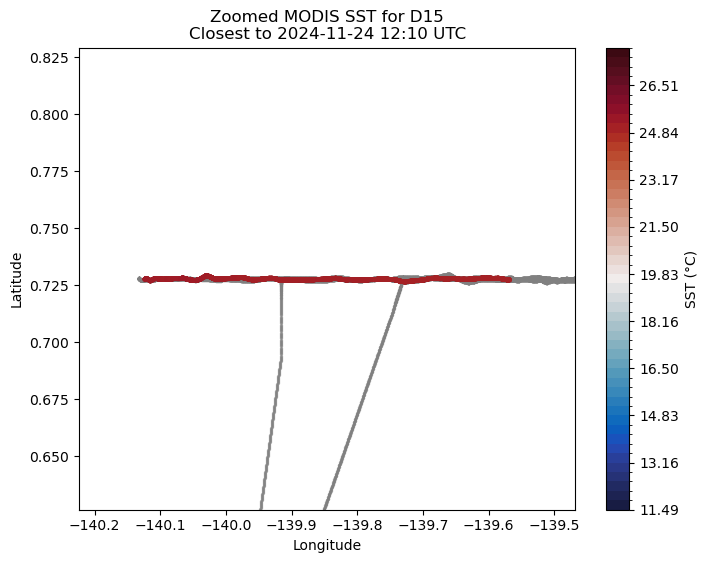

In [59]:
import numpy as np
import cmocean
import os

# Ensure datetime columns are parsed
df["mid_time"]      = df["mid_time"].dt.tz_localize(None)
df["start_time_UTC"] = pd.to_datetime(df["start_time_UTC"], utc=True).dt.tz_localize(None)
df["end_time_UTC"]   = pd.to_datetime(df["end_time_UTC"],   utc=True).dt.tz_localize(None)

ds_modis = xr.open_dataset('/Volumes/external/MOTIVE/data/MODIS/MODIS_sst_subset_20241112_20241124.nc')

# === Load ship dataset ===
ds_ship = xr.open_dataset('/Volumes/external/MOTIVE/data/skq202417s_met.nc')

# === Loop over front midpoints and extract nearest MODIS ===
for _, row in df.iterrows():
    front = row["front"]
    mid_time = row["mid_time"]

    # Make folder for this front if it doesn't exist
    outdir = f"/Volumes/external/MOTIVE/data/{front}"
    os.makedirs(outdir, exist_ok=True)

    # Find nearest MODIS time
    sst_mid = ds_modis['__xarray_dataarray_variable__'].sel(time=mid_time, method="nearest").sel(
        lon=slice(-145, -135),
        lat=slice(-0.5, 5)
    )

    # Convert from Kelvin to °C (MODIS L2P is in Kelvin)
    sst_mid = sst_mid - 273.15  

    modis_time = pd.to_datetime(sst_mid.time.values)

    # Ship subset during this front crossing
    ds_ship_subset = ds_ship.sel(time=slice(row["start_time_UTC"], row["end_time_UTC"]))

    # Shared vmin/vmax across MODIS + ship temps
    vmin = min(float(sst_mid.min()), float(ds_ship_subset.t.min()))
    vmax = max(float(sst_mid.max()), float(ds_ship_subset.t.max()))

    # Find nearest MODIS time & extract SST
    sst_mid = ds_modis["__xarray_dataarray_variable__"].sel(time=mid_time, method="nearest").sel(
        lon=slice(-145, -135),
        lat=slice(-0.5, 5)
    )

    # Convert from Kelvin to °C
    sst_mid = sst_mid - 273.15  
    
    # Skip if SST is all NaN
    if np.all(np.isnan(sst_mid)):
        print(f"⚠️ Skipping {front} at {mid_time} (all NaNs in MODIS)")
        continue
    
    modis_time = pd.to_datetime(sst_mid.time.values)
    
    # Ship subset during this front crossing
    ds_ship_subset = ds_ship.sel(time=slice(row["start_time_UTC"], row["end_time_UTC"]))
    
    # Shared vmin/vmax across MODIS + ship temps (ignore NaNs)
    vmin = min(
        float(np.nanmin(sst_mid.values)),
        float(np.nanmin(ds_ship_subset.t.values))
    )
    vmax = max(
        float(np.nanmax(sst_mid.values)),
        float(np.nanmax(ds_ship_subset.t.values))
)



    # === 1. Wide view ===
    plt.figure(figsize=(8,6))
    sst_mid.plot.contourf(
        levels=50,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={"label":"SST (°C)"}
    )

    plt.scatter(ds_ship.lon, ds_ship.lat, c='gray', alpha=0.9, s=2)
    plt.scatter(
        ds_ship_subset.lon,
        ds_ship_subset.lat,
        c=ds_ship_subset.t,
        s=1,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax
    )

    plt.title(
        f"MODIS SST near {front} crossing\n"
        f"Closest to {modis_time.strftime('%Y-%m-%d %H:%M UTC')}\n"
        f"(Ship {row['start_time_UTC']} → {row['end_time_UTC']})"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(-140.5, -136.87)
    plt.ylim(-0.2, 3)

    wide_path = os.path.join(outdir, f"{front}_MODIS_wide.png")
    plt.savefig(wide_path, dpi=300, bbox_inches="tight")
    plt.close()

    # === 2. Zoomed-in view ===
    lon_min = float(ds_ship_subset.lon.min()) - 0.1
    lon_max = float(ds_ship_subset.lon.max()) + 0.1
    lat_min = float(ds_ship_subset.lat.min()) - 0.1
    lat_max = float(ds_ship_subset.lat.max()) + 0.1

    plt.figure(figsize=(8,6))
    sst_mid.plot.contourf(
        levels=50,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={"label":"SST (°C)"}
    )

    plt.scatter(ds_ship.lon, ds_ship.lat, c='gray', alpha=0.5, s=2)
    plt.scatter(
        ds_ship_subset.lon,
        ds_ship_subset.lat,
        c=ds_ship_subset.t,
        s=6,
        cmap=cmocean.cm.balance,
        vmin=vmin, vmax=vmax
    )

    plt.title(
        f"Zoomed MODIS SST for {front}\n"
        f"Closest to {modis_time.strftime('%Y-%m-%d %H:%M UTC')}"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)

    zoom_path = os.path.join(outdir, f"{front}_MODIS_zoom.png")
    plt.savefig(zoom_path, dpi=300, bbox_inches="tight")
    plt.show()

    break   # uncomment if you want to stop after first front


In [53]:
ds_modis

<xarray.Dataset> Size: 125MB
Dimensions:                        (lon: 1000, lat: 550, time: 57)
Coordinates:
  * lon                            (lon) float64 8kB -145.0 -145.0 ... -135.0
  * lat                            (lat) float64 4kB -0.5 -0.49 ... 4.98 4.99
  * time                           (time) datetime64[ns] 456B 2024-11-11T11:4...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float32 125MB ...

In [55]:
ds_modis.__xarray_dataarray_variable__.values

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan, 297.13278, 297.15576, ...,       nan,       nan,
         291.1259 ],
        [      nan, 297.257  , 297.28674, ..., 293.07208, 292.7201 ,
               nan],
        ...,
        [      nan, 260.0041 , 259.99377, ..., 297.31403, 297.0357 ,
         296.44232],
        [      nan, 260.11115, 259.88257, ..., 297.09833, 296.41   ,
         295.82343],
        [      nan,       nan, 261.65952, ...,       nan, 294.46072,
         294.1538 ]],

       [[299.7517 , 299.70874, 299.63922, ...,       nan,       nan,
               nan],
        [299.69925, 299.71088, 299.74686, ...,       nan,       nan,
               nan],
        [299.6488 , 299.55692, 299.689  , ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
   